In [1]:
"""
Created on Tue Jul 9 16:48:32 2019

@author: Andrew Welsh

This notebook is for doing a model fit to as much historical data as possible, then saving the fitted model to pickled 
joblib files, which are then used for the live model runs (until the next model re-fit, done here).
The data must be extracted via SQL prior to inclusion in this notebook (until a data connection directly to the database 
is configured), then saved via CSV and uploaded here, which is then read here. 

The parameter tuning for this model fit is accomplished with the churn_grid_search_parameter_tuning notebook

Intended use is production model re-fitting process every 6 months.

Output: saved model fit files
"""

import pandas as pd
import churn_common as c #imports F2 score function, model_fit function

# imported data already has nulls cleaned and unused columns dropped
# churn_dedi_model_training_fit.csv is output from 'churn_dedi_model_training_fit.py' python script
dedicated_train = pd.read_csv('churn_dedi_model_training_fit.csv', encoding='ISO-8859-1')

print('Query complete')
pd.options.display.max_columns = None

Query complete


In [2]:
#index column from CSV is imported as a separate column, labeled 'Unnamed: 0', therefore must be dropped before model fit
dedicated_train.drop(['Unnamed: 0'], axis=1, inplace=True)

# Model evaluation scores are determined/estimated by the "churn_grid_search_parameter_tuning" and 
# "churn_model_fit - feature selection engineering" notebooks
# For production model fit, we use the whole dataset.

In [3]:
#==================================================================================================================
#==================================================================================================================
# Split data by revenue segment (per business request)
#==================================================================================================================
#==================================================================================================================
#split datasets into low-med-hi revenue segments
#live model fit (entire dataset)
dedicated_low, dedicated_mid, dedicated_hi = c.split_df_revenue_segments(dedicated_train, 'average_invoiced_last_12_months')

print("Data split by revenue segment")

#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================

#for repeatable results, set seed equal to an integer; for random assignment, set seed to None
seed = None

dedicated_low_rus = c.AndrewsRandomUnderSampler(dedicated_low, 'target', seed)
dedicated_mid_rus = c.AndrewsRandomUnderSampler(dedicated_mid, 'target', seed)
dedicated_hi_rus = c.AndrewsRandomUnderSampler(dedicated_hi, 'target', seed)

print('Minority class resampling complete')

Data split by revenue segment
Minority class resampling complete


In [4]:
#define lists of target (y) and predictor (x) columns
exclude_col = ['target'
               ,'average_invoiced_last_12_months'
               ,'account_number'
               ,'time_month_key'
               ,'month_order'
               ]

predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(c.dedi_model_fit_include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(c.dedi_model_fit_include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(c.dedi_model_fit_include_col_hi)])


#create copy of the X and Y columns for live model fit on entire dataset
x_live_low = dedicated_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_live_low = dedicated_low_rus['target']

x_live_mid = dedicated_mid_rus[predictors_mid]
y1_live_mid = dedicated_mid_rus['target']

x_live_hi = dedicated_hi_rus[predictors_hi]
y1_live_hi = dedicated_hi_rus['target']

print("Predictor and target datasets ready")

Predictor and target datasets ready


In [5]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import time
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/app/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/app/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)



Model Fit Start time
2020-04-30 19:11:07


avg_invoiced_in_last_3_months_vs_prior_3_months    251466
avg_invoiced_in_last_6_months_vs_prior_6_months    242190
total_invoiced_in_last_6_months                    228597
shortest_active_device_tenure_months               164207
pct_of_device_status_eq_online_complete            135110
dtype: int64

Model Fit End time
2020-04-30 19:29:34

Model Fit Start time
2020-04-30 19:29:34


total_invoiced_in_last_6_months                                   22099
avg_invoiced_in_last_6_months_vs_prior_6_months                   19952
pct_of_device_status_eq_online_complete                           19232
avg_invoiced_in_last_3_months_vs_prior_3_months                   18061
ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    16992
dtype: int64

Model Fit End time
2020-04-30 19:31:22

Model Fit Start time
2020-04-30 19:31:22


total_invoiced_in_last_6_months                                   9291
ratio_num_of_invoiced_items_in_last_6_mon

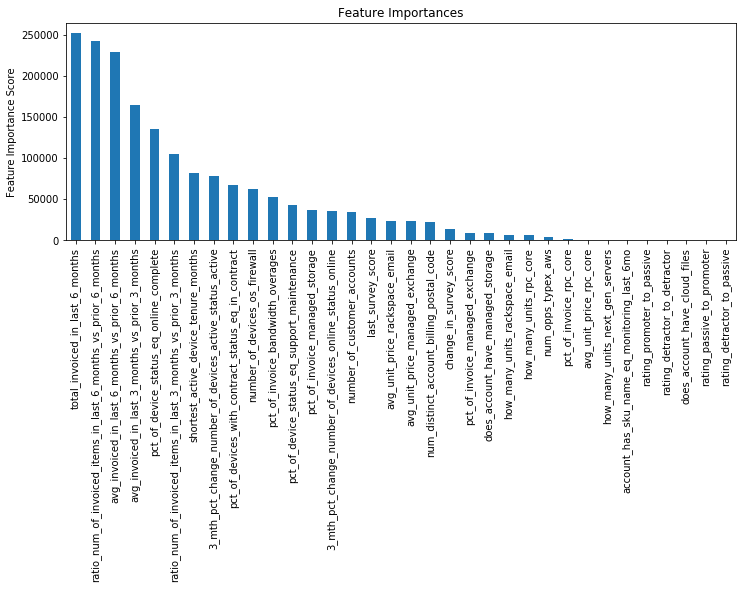

In [6]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Model run - for live data (train on entire dataset)
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================

xgb_final_low = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.7,
        gamma=0, 
        learning_rate=0.005,
        max_delta_step=2, 
        max_depth=14, 
        max_features=13, 
        min_child_weight=0, 
        n_estimators=1750, 
#        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1e-05,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)

xgb_final_mid = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=1, 
        learning_rate=0.01,
        max_delta_step=1, 
        max_depth=11, 
        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)


xgb_final_hi = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.7,
        gamma=1, 
        learning_rate=0.01,
        max_delta_step=0, 
        max_depth=13, 
        max_features=13, 
        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=1e-05,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)

c.modelfit(xgb_final_low, x_live_low, y1_live_low.values.ravel(), predictors_low)
c.modelfit(xgb_final_mid, x_live_mid, y1_live_mid.values.ravel(), predictors_mid)
c.modelfit(xgb_final_hi, x_live_hi, y1_live_hi.values.ravel(), predictors_hi)

In [7]:
import joblib

In [8]:
#save fitted model for use in production (monthly)
model_save_low = 'churn_dedi_model_fit_low.sav'
model_save_mid = 'churn_dedi_model_fit_mid.sav'
model_save_hi = 'churn_dedi_model_fit_hi.sav'
joblib.dump(xgb_final_low, model_save_low)
joblib.dump(xgb_final_mid, model_save_mid)
joblib.dump(xgb_final_hi, model_save_hi)

['churn_dedi_model_fit_hi.sav']